In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import tree
from dtreeviz.trees import DTreeVizAPI
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import defaultdict
from xgboost.sklearn import XGBClassifier


In [2]:
loan200 = pd.read_csv('Data/loan200.csv')
loan200.head()

loandata = pd.read_csv('Data/loan_data.csv.gz',compression='gzip')
loandata.columns

loan3000 = pd.read_csv('Data/loan3000.csv')

In [19]:
loandata.shape

(45342, 21)

In [3]:
#Simple Demo of knn

predictors = ['payment_inc_ratio','dti']
outcome = ['outcome']

newloan = loan200.loc[0:0,predictors]
X = loan200.loc[1:,predictors]
y = loan200.loc[1:,outcome]

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X,y)
print(knn.predict(newloan))
print(knn.predict_proba(newloan))

['default']
[[0.6 0.4]]


c:\Users\chira\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [4]:
#VIF Variance Inflation Factor
import numpy as np
import pandas as pd
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#create dataset
df = pd.DataFrame({'rating': [90, 85, 82, 88, 94, 90, 76, 75, 87, 86],
                   'points': [25, 20, 14, 16, 27, 20, 12, 15, 14, 19],
                   'assists': [5, 7, 7, 8, 5, 7, 6, 9, 9, 5],
                   'rebounds': [11, 8, 10, 6, 6, 9, 6, 10, 10, 7]})

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('rating ~ points+assists+rebounds', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif


,VIF,variable
0,101.258171,Intercept
1,1.763977,points
2,1.959104,assists
3,1.175030,rebounds


In [6]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = ['outcome']

# y,X = dmatrices('outcome ~ payment_inc_ratio+dti+revol_bal+revol_util',data=loandata,return_type='dataframe')
# vif = pd.DataFrame()
# vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
# vif['variable'] = X.columns
# print(vif)

newloan = loandata.loc[0:0,predictors]
X = loandata.loc[1:,predictors]
y = loandata.loc[1:,outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)

nbrs = knn.kneighbors(newloan)
X.loc[nbrs[1][0],:]


c:\Users\chira\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,payment_inc_ratio,dti,revol_bal,revol_util
35535,8.30143,11.38,10074,69.5
33650,7.04082,21.81,25639,76.1
25862,4.14828,12.96,7302,88.0
42952,9.14223,1.23,7918,19.8
43598,2.50637,7.65,43305,48.7


In [12]:
#sTANDARDIZATION
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = ['outcome']

newloan = loandata.loc[0:0,predictors]
X = loandata.loc[1:,predictors]
y = loandata.loc[1:,outcome]

scaler = StandardScaler()
scaler.fit(X*1)

X_std = scaler.transform(X*1)
newloan_std = scaler.transform(newloan*1)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std,y)

nbrs = knn.kneighbors(newloan_std)
X.iloc[nbrs[1][0],:]

print(knn.predict(newloan_std))

c:\Users\chira\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


['paid off']


In [4]:
#KNN Feature engine
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util','delinq_2yrs_zero','open_acc','pub_rec_zero']
outcome = ['outcome']

newloan = loandata.loc[0:0,predictors]
X = loandata[predictors]
y = loandata[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X,y)

loandata['borrower_score'] = knn.predict_proba(X)[:,1]
loandata['borrower_score'].describe()

c:\Users\chira\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


count    45342.000000
mean         0.500776
std          0.129490
min          0.050000
25%          0.400000
50%          0.500000
75%          0.600000
max          1.000000
Name: borrower_score, dtype: float64

# Tree Models

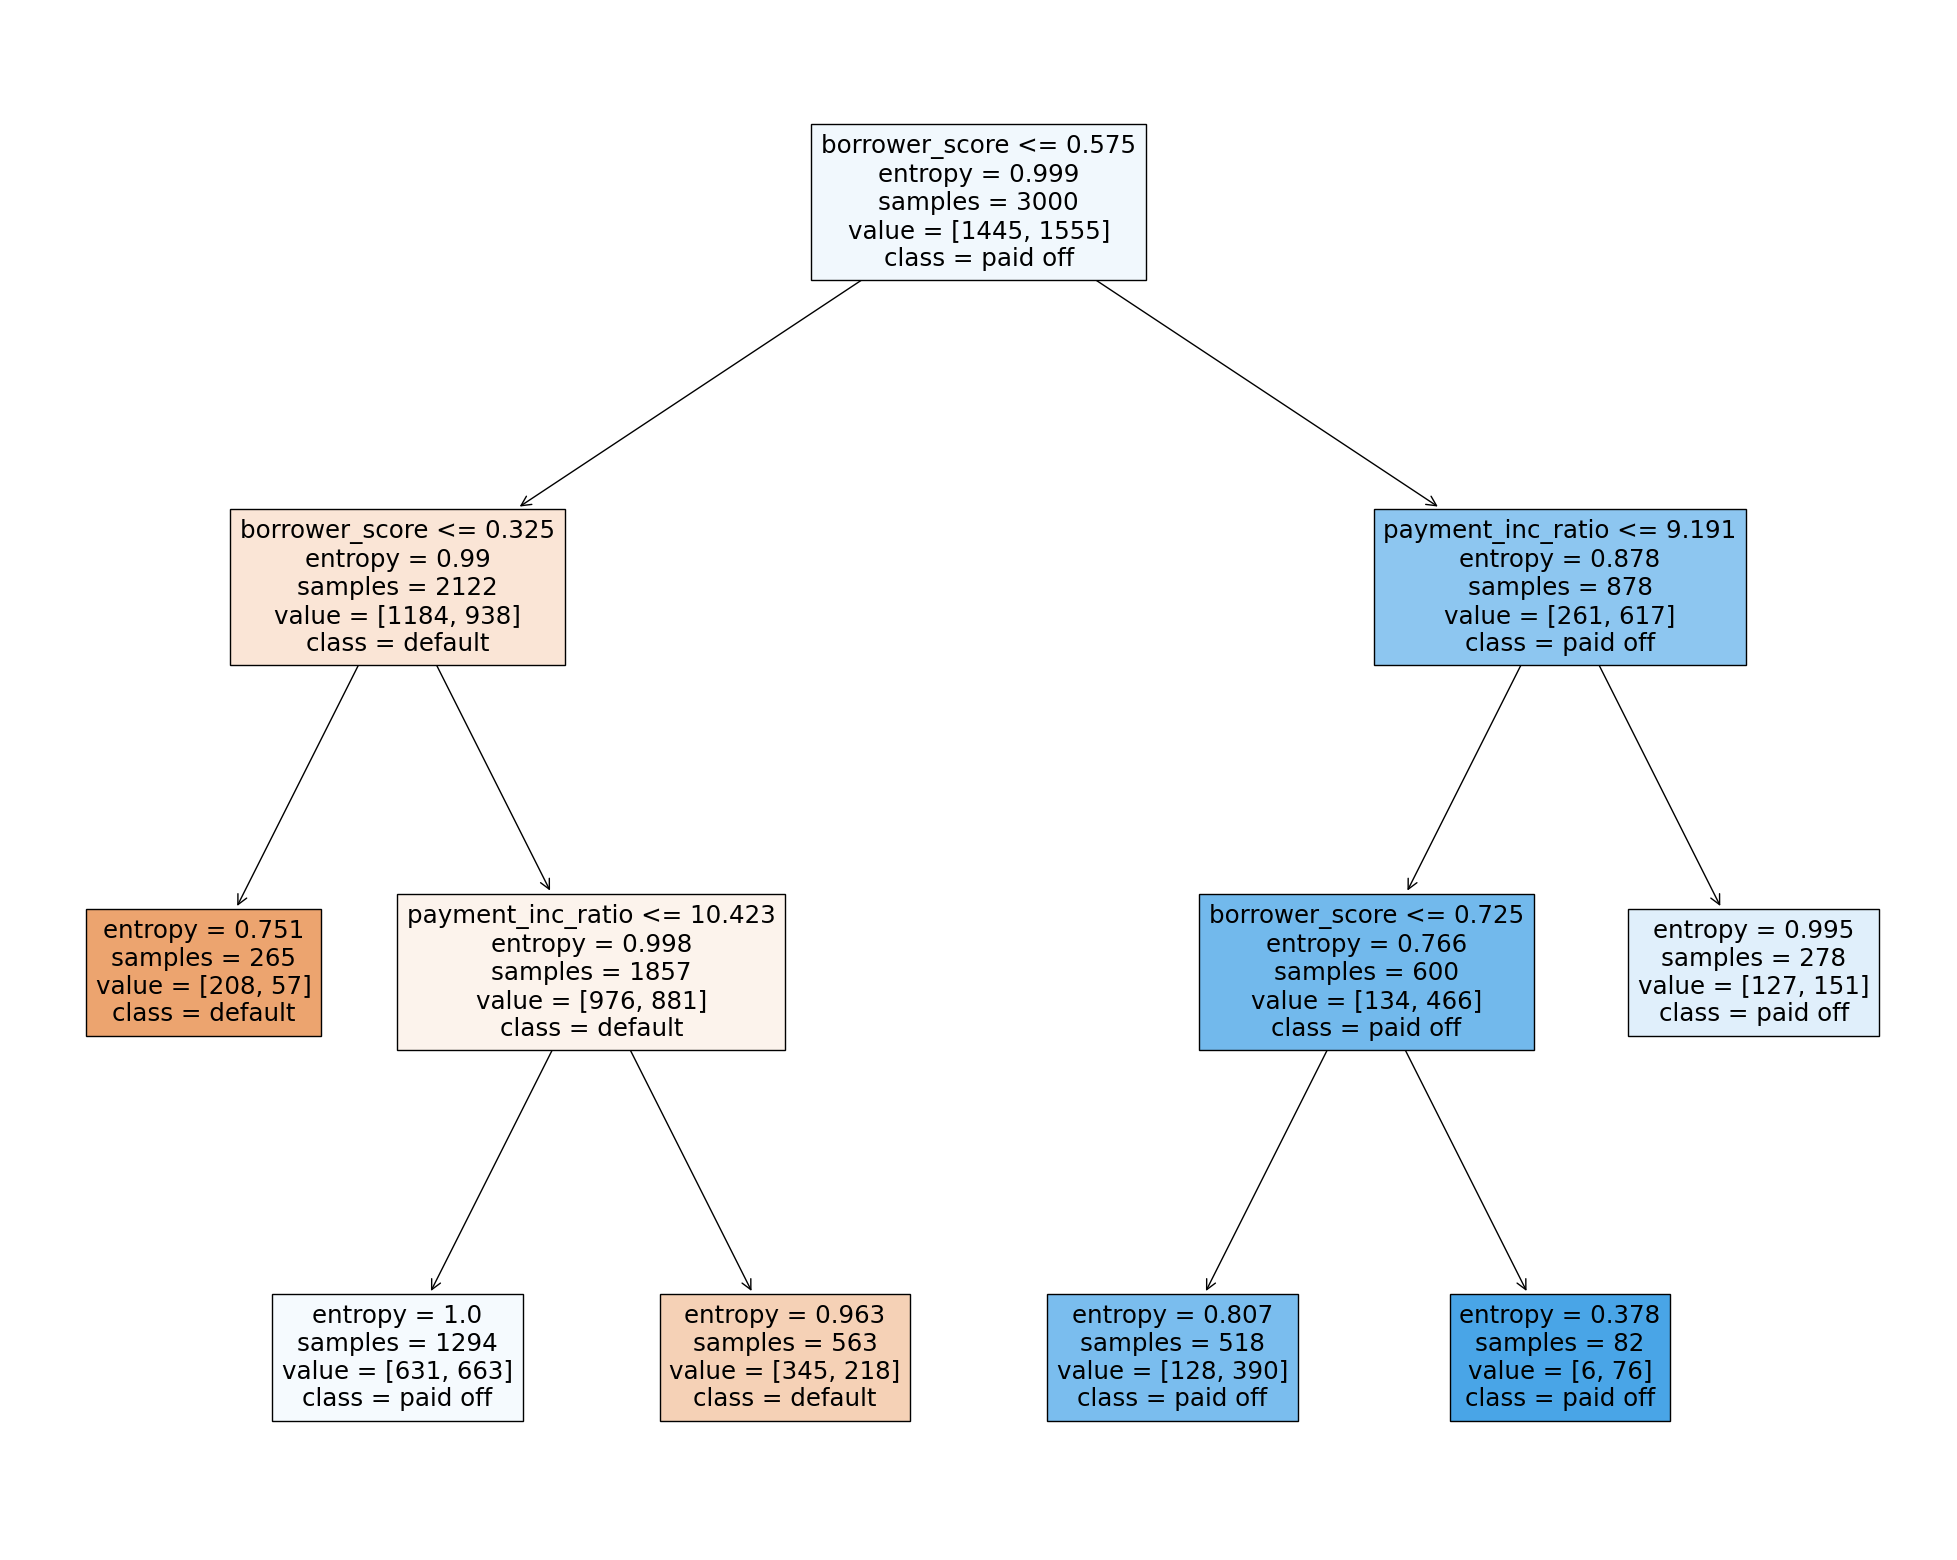

In [3]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = ['outcome']

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = tree.DecisionTreeClassifier(random_state=1,criterion='entropy',min_impurity_decrease=0.003)

loan_tree.fit(X,y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(loan_tree,feature_names=predictors,class_names=loan_tree.classes_,filled=True)


In [5]:
print(tree.export_text(loan_tree))

|--- feature_0 <= 0.58
|   |--- feature_0 <= 0.33
|   |   |--- class: default
|   |--- feature_0 >  0.33
|   |   |--- feature_1 <= 10.42
|   |   |   |--- class: paid off
|   |   |--- feature_1 >  10.42
|   |   |   |--- class: default
|--- feature_0 >  0.58
|   |--- feature_1 <= 9.19
|   |   |--- feature_0 <= 0.72
|   |   |   |--- class: paid off
|   |   |--- feature_0 >  0.72
|   |   |   |--- class: paid off
|   |--- feature_1 >  9.19
|   |   |--- class: paid off



# Bagging and Random Forest

In [4]:
#Random forest
predictors = ['borrower_score','payment_inc_ratio']
outcome = ['outcome']

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1,oob_score=True)
rf.fit(X,y)

C:\Users\chira\AppData\Local\Temp\ipykernel_11944\2184065123.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

In [ ]:
#Tracking error rate of thetrained models at different tree lenghts
predictors = ['borrower_score','payment_inc_ratio']
outcome = ['outcome']

X = loan3000[predictors]
y = loan3000[outcome]

scaler = StandardScaler()

scaler.fit(X*1)
X_std = scaler.transform(X*1)

n_estimator = list(range(5,20))
oob_scores = dict()

for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n,random_state=47,oob_score=True)
    rf.fit(X_std,y.values.ravel())

    oob_scores[n] = rf.oob_score_

df = pd.DataFrame(oob_scores.items(),columns=['n','oob_score'])
df.plot(x='n',y='oob_score')

In [3]:
#cross validation of data sets and variable inportancs
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero',
'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_',
'home_', 'emp_len_', 'borrower_score']
outcome = ['outcome']

X = loandata[predictors]
X = pd.get_dummies(X,drop_first=True)
y = loandata[outcome]
scores = defaultdict(list)
rf = RandomForestClassifier(n_estimators=500, random_state=1)

for _ in range(3):
    xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.3)
    rf.fit(xtrain,ytrain.values.ravel())
    acc = metrics.accuracy_score(ytest,rf.predict(xtest))
    for column in X.columns:
        xt = xtest.copy()
        xt[column] = np.random.permutation(xt[column].values)
        shuff_acc = metrics.accuracy_score(ytest, rf.predict(xt))
        scores[column].append((acc-shuff_acc)/acc)
    

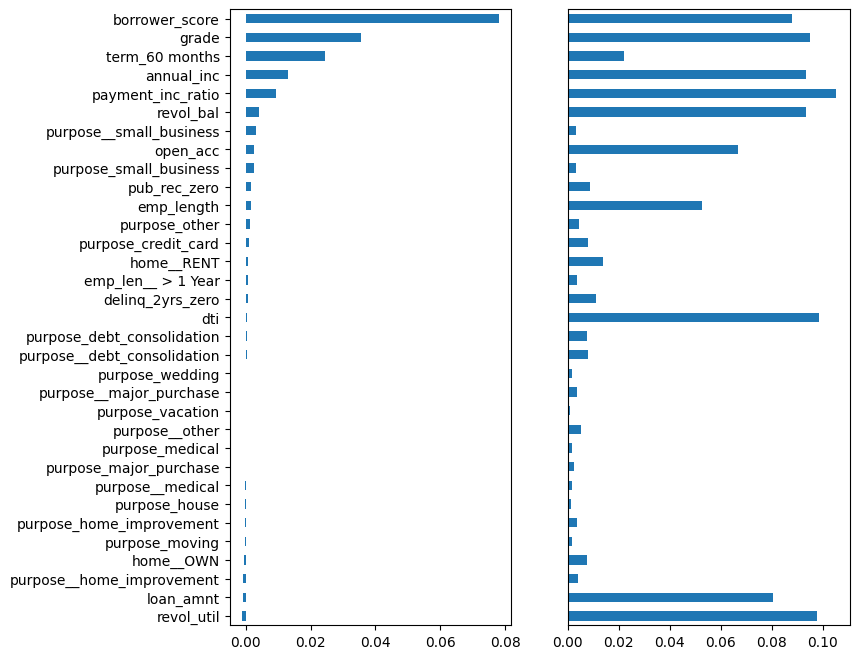

In [6]:
df = pd.DataFrame({
'feature': X.columns,
'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
'Gini decrease': rf.feature_importances_,
})

df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease',
legend=False, ax=axes[0])

ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease',
legend=False, ax=axes[1])

ax.set_ylabel('')

ax.get_yaxis().set_visible(False)

In [3]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

le = LabelEncoder()

X = loan3000[predictors]
y = le.fit_transform(loan3000[outcome])

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
max_delta_step=0, max_depth=3, min_child_weight=1, missing=np.nan,
n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic',
random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
silent=None, subsample=0.63, verbosity=1)

xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=3, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

Text(0, 0.5, 'payment_inc_ratio')

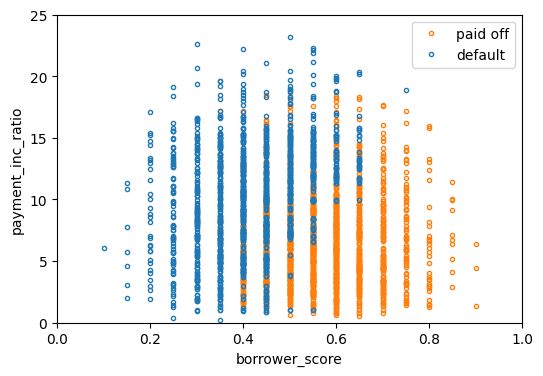

In [10]:
#vizualizing the results
xgb_df = X.copy()
xgb_df['predictions'] = xgb.predict(X)
xgb_df['predictions'] =np.select([xgb_df.predictions == 1,xgb_df.predictions == 0],['paid off','default'])

fig,ax = plt.subplots(figsize=(6,4))

xgb_df.loc[xgb_df.predictions == 'paid off'].plot(
    x = 'borrower_score',y='payment_inc_ratio',style = '.',
    markerfacecolor = 'none',markeredgecolor='C1',ax=ax
)
xgb_df.loc[xgb_df.predictions == 'default'].plot(
    x = 'borrower_score',y='payment_inc_ratio',style = '.',
    markerfacecolor = 'none',markeredgecolor='C0',ax=ax
)

ax.legend(['paid off','default'])
ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

default test error:  35.510000000000005 %
default train error: 12.54032029879464 %
penalty test error:  32.83 %
penalty train error:  31.29704034859374 %


c:\Users\chira\miniconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<AxesSubplot: xlabel='iterations'>

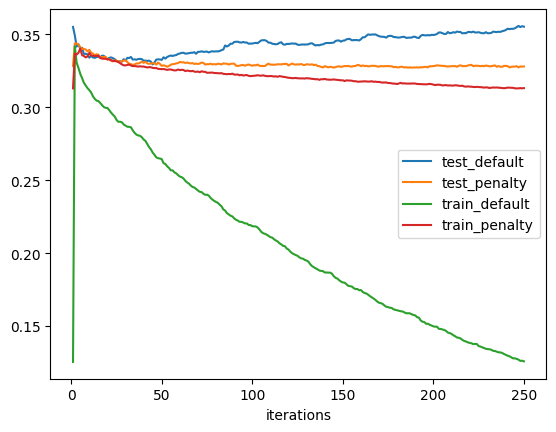

In [37]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero',
'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_',
'home_', 'emp_len_', 'borrower_score']

outcome = 'outcome'

X = pd.get_dummies(loandata[predictors],drop_first=True)
y = loandata[outcome]
y = np.select([y == 'paid off',y == 'default'],[0,1])


trainx,testx,trainy,testy = train_test_split(X,y,random_state=1,test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic',n_estimators=250,max_depth=6,
                    reg_lambda = 0,learning_rate=.3,subsample=1)

xgb_default.fit(trainx,trainy)

xgb_default_preds = xgb_default.predict_proba(testx)[:,1]
error_default = abs(testy - xgb_default_preds) > 0.5
print('default test error: ',np.mean(error_default)*100,'%')
print('default train error:',100 - (xgb_default.score(trainx,trainy)*100),'%')

#with regularization parameter lambmda included
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250,
max_depth=6, reg_lambda=1000, learning_rate=0.1,
subsample=0.63)
xgb_penalty.fit(trainx, trainy)
pred_penalty = xgb_penalty.predict_proba(testx)[:, 1]
error_penalty = abs(testy - pred_penalty) > 0.5
print('penalty test error: ', np.mean(error_penalty)*100,'%')
print('penalty train error: ',100 - (xgb_penalty.score(trainx,trainy)*100),'%')

#comparing in sample and out of sample error rates as mopre models are included
results  = []
for i in range(250):
    train_default = xgb_default.predict_proba(trainx, ntree_limit=i)[:, 1]
    train_penalty = xgb_penalty.predict_proba(trainx,ntree_limit=i)[:, 1]
    test_default = xgb_default.predict_proba(testx,ntree_limit=i)[:, 1]
    test_penalty = xgb_penalty.predict_proba(testx,ntree_limit=i)[:, 1]

    results.append({
        'iterations':i+1,
        'train_default': np.mean(abs(trainy - train_default) > 0.5),
        'train_penalty': np.mean(abs(trainy - train_penalty) > 0.5),
        'test_default': np.mean(abs(testy - test_default) > 0.5),
        'test_penalty': np.mean(abs(testy - test_penalty) > 0.5),
    })

results_df = pd.DataFrame(results)
results_df.head()

ax = results_df.plot(x='iterations', y='test_default')
results_df.plot(x='iterations', y='test_penalty', ax=ax)
results_df.plot(x='iterations', y='train_default', ax=ax)
results_df.plot(x='iterations', y='train_penalty', ax=ax)

In [1]:
import pandas as pd

In [2]:


# Sample data
data = {
    'user_id': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    'timestamp': ['2019-04-25 13:30:15', '2019-04-25 13:30:18', '2019-04-25 13:30:40', '2019-04-25 13:30:45', 
                  '2019-04-25 13:31:10', '2019-04-25 13:31:25', '2019-04-25 13:31:40', '2019-04-25 13:40:00',
                  '2019-04-25 13:40:10', '2019-04-25 13:40:15', '2019-04-25 13:40:20', '2019-04-25 13:40:25',
                  '2019-04-25 13:40:30', '2019-04-25 13:40:35', '2019-04-25 13:41:21', '2019-04-25 13:41:30',
                  '2019-04-25 13:41:35', '2019-04-25 13:41:40', '2019-04-26 11:15:00', '2019-04-26 11:15:10',
                  '2019-04-26 11:15:20', '2019-04-26 11:15:25', '2019-04-26 11:15:35', '2019-04-28 14:30:15',
                  '2019-04-28 14:30:10', '2019-04-28 13:30:40', '2019-04-28 15:31:40'],
    'action': ['page_load', 'page_load', 'scroll_down', 'scroll_up', 'scroll_down', 'scroll_down', 'page_exit',
               'page_load', 'scroll_down', 'scroll_down', 'scroll_down', 'scroll_down', 'scroll_down', 'page_exit',
               'page_load', 'scroll_down', 'scroll_down', 'scroll_up', 'page_load', 'scroll_down', 'scroll_down',
               'scroll_up', 'page_exit', 'page_load', 'page_load', 'scroll_down', 'page_exit']
}

df = pd.DataFrame(data)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter page_load and page_exit actions
df = df[df['action'].isin(['page_load', 'page_exit'])]

# Group by user_id
grouped = df.groupby('user_id')

# # Calculate session time for each user
# def calculate_session_time(group):
#     page_load = group[group['action'] == 'page_load']['timestamp'].max()
#     page_exit = group[group['action'] == 'page_exit']['timestamp'].min()
#     session_time = page_exit - page_load
#     return session_time.total_seconds() / 60  # Convert to minutes

# session_times = grouped.apply(calculate_session_time)

# # Calculate average session time for each user
# average_session_time = session_times.groupby('user_id').mean()

# print(average_session_time)


In [6]:
grouped